In [1]:
import torch
torch.cuda.is_available()

False

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import MNIST


In [4]:
BATCH_SIZE = 128

transform = transforms.Compose([
      transforms.ToTensor(), # first, convert image to PyTorch tensor
      transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
    ])

mnist_train = MNIST('data',train=True,transform=transform, download=True)
mnist_test = MNIST('data',train=False,transform=transform, download=True)

dl_train = DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, 
                      num_workers=0, drop_last=True, shuffle=True)
dl_test = DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE, 
                     num_workers=0, drop_last=False, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



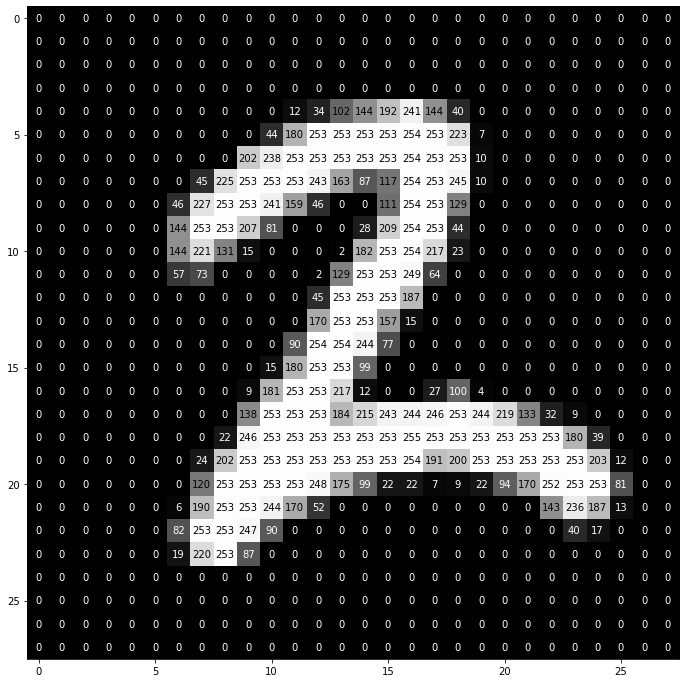

In [6]:
idx = np.random.choice(np.arange(0, len(mnist_train)))
img = mnist_train.data[idx]
img = np.reshape(img, (28, 28))

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = int(img[x][y]) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

/tmp/ipykernel_324030/405538749.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  subplots[i].grid(b=False)


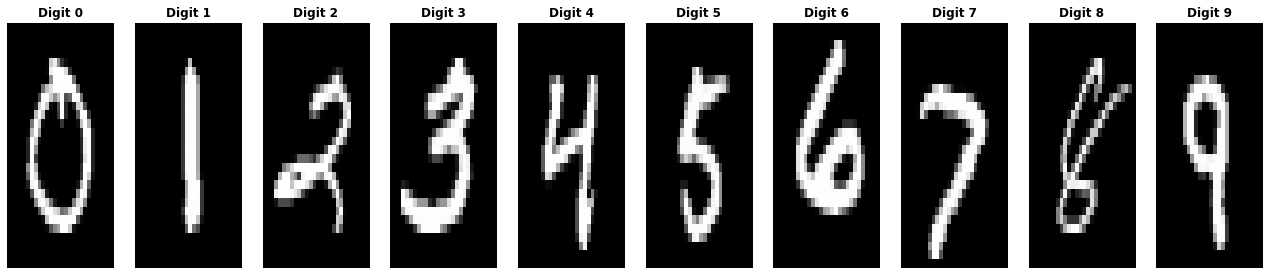

In [7]:
num_row, num_col = 1, 10
f,subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

for i in range(num_col):
    X, y = iter(dl_train).next()
    X_img = X[y == i]
    idx = np.random.choice(np.arange(0, X_img.shape[0]))
    
    X_img = X_img[idx]
    X_img = X_img.detach().cpu().numpy()
    X_img = X_img.squeeze()
    
    subplots[i].imshow(X_img, cmap='gray',
                       interpolation='nearest', 
                       aspect='auto')
    subplots[i].set_title(f'Digit {i}', fontweight="bold")
    subplots[i].grid(b=False)
    subplots[i].axis('off')

f.set_size_inches(22.5, 4.5)

In [8]:
import torch 

num_epochs    = 10
num_fin       = 784
num_classes   = 10
num_hidden    = 128
learning_rate = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
import torch
import torch.nn as nn
from torch.optim import SGD

"""
    Write HERE your multi layer perceptron (MLP), with one hidden layer 
    characterised by num_hidden neurons, activated by one OF the following
    activation functions: sigmoid, relu, leaky_relu (see the torch.nn package
    for details about act. functions)

    Here a list of functions that you may use: 
      - nn.Sequential
      - nn.Linear
      - nn.Sigmoid
      - nn.ReLU
      - torch.argmax
      - optim.SGD, optim.Adam
      - nn.CrossEntropyLoss
      
    OPTIONALLY: 
    i) Add more than just one hidden layer. 
    ii) Put dropout and batch normalization layers to respectively improve
    the generalization capabilities and speedup training procedure.
"""

class MLP(nn.Module):
  
  def __init__(self, num_fin: int, num_hidden: int, num_classes: int):
    super(MLP, self).__init__()

    self.num_fin = num_fin
    self.num_hidden = num_hidden
    self.num_classes = num_classes

    """
    Define MLP building blocks here.
    """
    self.net = nn.Sequential(
                    nn.Linear(num_fin, num_hidden),
                    nn.ReLU(),
                    nn.Linear(num_hidden, num_classes)
    )
  

  def forward(self, x: torch.Tensor):    
    """
    x: input grayscale images (28x28) -> shape (B, 1, 28, 28)
    y: output predictions -> shape (B, self.num_classes)
    """

    return self.net(torch.flatten(x, 1))


def eval_acc(mlp: nn.Module, data_loader: torch.utils.data.DataLoader, 
             device: torch.device):
  
  correct = 0
  total = 0
  
  with torch.no_grad():
    for x, y in data_loader:
      x, y = x.to(device), y.to(device)
      y_pred = mlp(x)
      """
      Given y_pred (predictions) and y (groundtruth labels), acc
      should contain the number of right predictions.
      """
      y_pred_discr = torch.argmax(y_pred, dim=1)

      acc = torch.sum((y == y_pred_discr).float())
      
      correct += acc
      total += y_pred.size(0)
  
  return correct/total

In [16]:
"""
Define here the major components of the training algorithm. 
"""
model     = MLP(num_fin,num_hidden,num_classes).to(device)
loss_fun  = nn.CrossEntropyLoss().to(device)
opt       = SGD(model.parameters(), lr=learning_rate)

try:
  
    for i in range(num_epochs):
      
      # Compute and print the accuracy, both on the training and the test set. 
      print(f"Epoch {i} train acc.: {eval_acc(model, dl_train, device):.3f} "
                        f"test acc.: {eval_acc(model, dl_test, device):.3f}")
      
      """
      Write HERE your code
      For each batch in the training set:
           -> Clear the gradients of all optimized variables
           -> Load the batch into the device.
           -> Forward pass: compute the predicted outputs by passing 
              inputs to the model
           -> Given the predictions, compute the loss function. 
           -> Backward pass: compute gradient of the loss with respect 
              to model parameters
           -> Make an optimization step. 
      """
      #count = 0
      for i,data in enumerate(dl_train):
         #count += BATCH_SIZE
         inputs,labels = data
         x,y = inputs.to(device), labels.to(device)
         opt.zero_grad()
         y_pred = model(x)
         loss = loss_fun(y_pred,labels)
         loss.backward()
         opt.step()
      #print("count {}",count) #-> 60K

      
except KeyboardInterrupt:
    pass

Epoch 0 train acc.: 0.085 test acc.: 0.078
Epoch 1 train acc.: 0.889 test acc.: 0.895
Epoch 2 train acc.: 0.907 test acc.: 0.911
Epoch 3 train acc.: 0.916 test acc.: 0.919
Epoch 4 train acc.: 0.924 test acc.: 0.926
Epoch 5 train acc.: 0.929 test acc.: 0.930
Epoch 6 train acc.: 0.935 test acc.: 0.936
Epoch 7 train acc.: 0.939 test acc.: 0.938
Epoch 8 train acc.: 0.942 test acc.: 0.942
Epoch 9 train acc.: 0.945 test acc.: 0.944


/tmp/ipykernel_324030/1528724402.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  subplots[i,j].grid(b=False)


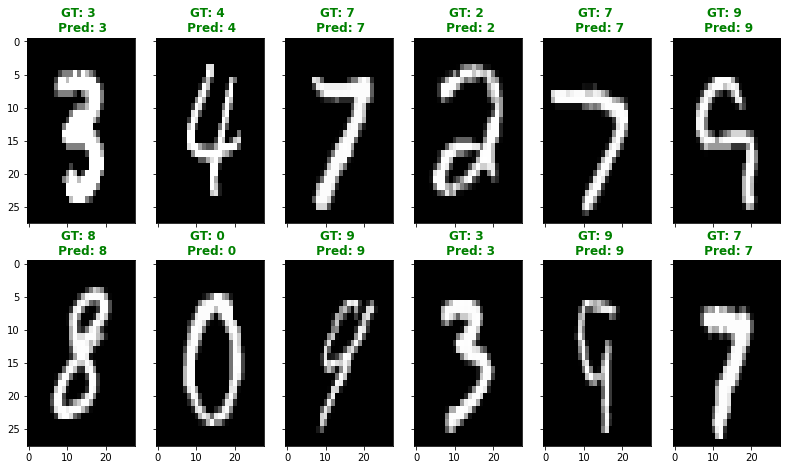

In [17]:
num_row, num_col = 2, 6
f,subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

X_batch, Y_batch = next(iter(dl_test))
X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

with torch.no_grad():
  Y_batch_pred = model(X_batch)

for i in range(num_row):
    for j in range(num_col):
      
        idx = np.random.choice(np.arange(0, X_batch.shape[0]))
        
        img = X_batch[idx].detach().cpu().numpy()
        
        target, pred = Y_batch[idx], Y_batch_pred[idx]
        target, pred = target.item(), torch.argmax(pred).item()
        target, pred = int(target), int(pred)
        is_correct = target == pred
                  
        subplots[i,j].imshow(img.squeeze(), cmap="gray", interpolation='nearest', 
                             aspect="auto")
        
        title = f"GT: {target} \n Pred: {pred}"
        color_title = 'green' if is_correct else 'red'
        subplots[i,j].set_title(title, color=color_title, fontweight="bold")
        subplots[i,j].grid(b=False)

f.set_size_inches(13.5, 7.5)